## Consuming data using Kafka and Visualise (20%)
In this task, we will implement an Apache Kafka consumer to consume the data from Part 2.  
  
Important:   
-	In this part, Kafka consumers are used to consume the streaming data published from task 2.8.

Main: Creating log output widget...


Output()

Main: Initializing plots...


<IPython.core.display.Javascript object>


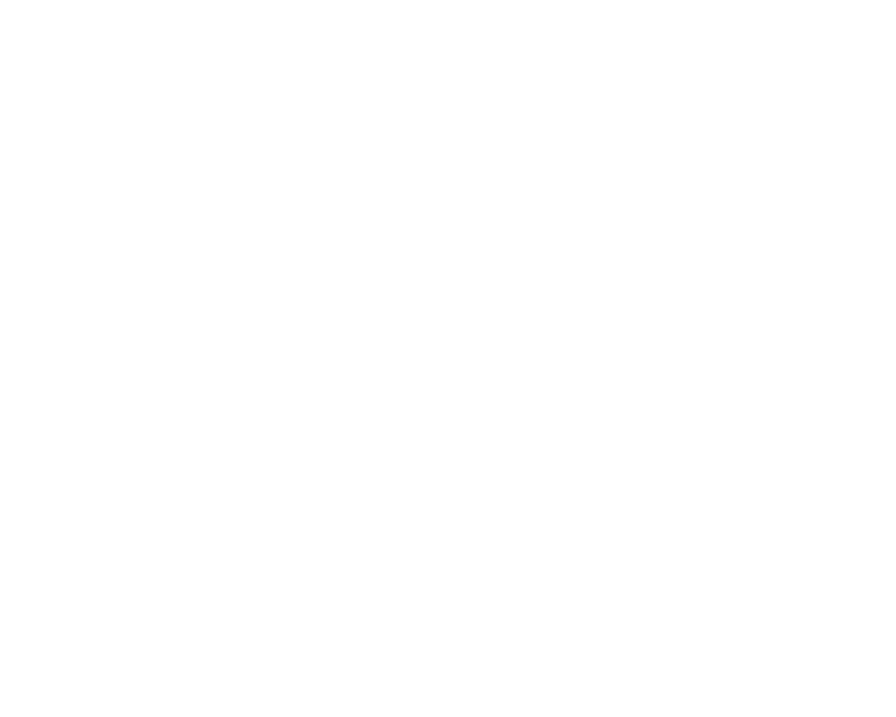

<IPython.core.display.Javascript object>


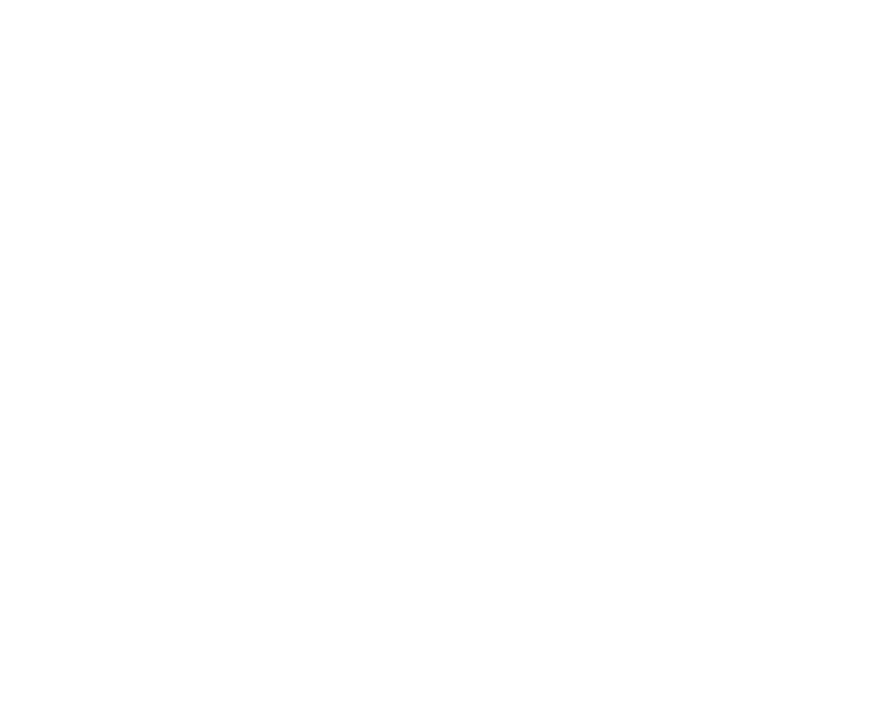

Main: Plot figures created.


In [1]:
# This is your corrected Task 3 cell with a Jupyter Log Widget
from kafka3 import KafkaConsumer
import json
import matplotlib.pyplot as plt
from datetime import datetime
from threading import Thread, Lock
import time
import copy
import ipywidgets as widgets
from IPython.display import display

# This magic command is necessary for live plotting in Jupyter
%matplotlib notebook

# --- 1. Configuration ---
hostip = "192.168.0.6"
topic_building = "building_6h"
topic_site = "site_daily"
PLOT_UPDATE_INTERVAL = 5 # 5 seconds
DATA_BUFFER_DAYS = 7 # Store 7 days of data

# --- 2. Shared Data Stores, Lock, and Max Y-Values ---
data_lock = Lock()
data_store_building = {}
data_store_site = {}
max_y_building = 500
max_y_site = 5000

# --- 3. Kafka Connection Function (Unchanged) ---
def connect_kafka_consumer(topic):
    """Connects to a specific Kafka topic."""
    return KafkaConsumer(
        topic,
        bootstrap_servers=[f'{hostip}:9092'],
        auto_offset_reset='earliest', 
        value_deserializer=lambda x: json.loads(x.decode('utf-8')),
        request_timeout_ms=10000 
    )

# --- 4. Consumer Functions (Data Collection ONLY) ---
# --- NOTICE: All print calls are now 'with log_widget: print(...)' ---

def consume_building_6h(consumer, log_widget):
    """
    Consumes from 'building_6h'.
    This function ONLY updates the shared data_store_building.
    """
    global max_y_building
    with log_widget:
        print(f"[{topic_building}] Starting consumer thread...")
    
    try:
        with log_widget:
            print(f"[{topic_building}] Consumer connected. Waiting for messages...")
        
        msg_count = 0
        for message in consumer:
            msg_count += 1
            if msg_count % 100 == 0: 
                with log_widget:
                    print(f"[{topic_building}] ... {msg_count} messages received ...")

            msg = message.value
            bldg_id = msg.get('building_id')
            time_bucket = msg.get('time')
            val = msg.get('total_power_6h') # This can be 0.0
            date_str = msg.get('date', "Unknown Date") 
            
            # --- THIS IS THE FIX ---
            # We now check for 'None' explicitly, just like in consume_site_daily.
            # This prevents 0.0 values from being filtered out.
            if bldg_id is None or time_bucket is None or val is None or date_str == "Unknown Date":
                continue
            # --- END OF FIX ---
                
            bldg_id_str = str(bldg_id)

            with data_lock:
                if date_str not in data_store_building:
                    data_store_building[date_str] = {
                        "0-6h": {}, "6-12h": {}, "12-18h": {}, "18-24h": {}
                    }
                data_store_building[date_str][time_bucket][bldg_id_str] = val
                if val > max_y_building:
                    max_y_building = val

    except Exception as e:
        with log_widget:
            print(f"CRITICAL Error in consumer for {topic_building}: {e}")
    finally:
        with log_widget:
            print(f"Closing consumer for {topic_building}")
        consumer.close()


def consume_site_daily(consumer, log_widget):
    """
    Consumes from 'site_daily'.
    This function ONLY updates the shared data_store_site.
    """
    global max_y_site
    with log_widget:
        print(f"[{topic_site}] Starting consumer thread...")
    all_sites = [str(i) for i in range(16)]
    
    try:
        with log_widget:
            print(f"[{topic_site}] Consumer connected. Waiting for messages...")
        
        msg_count = 0
        for message in consumer:
            msg_count += 1
            if msg_count % 20 == 0: # Print a heartbeat every 20 messages
                 with log_widget:
                    print(f"[{topic_site}] ... {msg_count} messages received ...")
            
            msg = message.value
            site_id = msg.get('site_id')
            val = msg.get('total_power_day')
            date_str = msg.get('date', "Unknown Date") 
            
            if site_id is None or val is None or date_str == "Unknown Date":
                continue
                
            site_id_str = str(site_id)

            with data_lock:
                if date_str not in data_store_site:
                    data_store_site[date_str] = {site: 0 for site in all_sites}
                data_store_site[date_str][site_id_str] = val
                if val > max_y_site:
                    max_y_site = val

    except Exception as e:
        with log_widget:
            print(f"CRITICAL Error in consumer for {topic_site}: {e}")
    finally:
        with log_widget:
            print(f"Closing consumer for {topic_site}")
        consumer.close()

# --- 5. Plotting Function (Runs in its own Thread) ---

def redraw_plots(fig_building, axes_building, fig_site, axes_site, log_widget):
    """
    This function runs in a loop, redrawing all plots
    every PLOT_UPDATE_INTERVAL seconds.
    """
    with log_widget:
        print(f"Starting redraw thread. Updates every {PLOT_UPDATE_INTERVAL}s.")
        
    time_buckets = ["0-6h", "6-12h", "12-18h", "18-24h"]
    ax_map = {
        "0-6h": axes_building[0, 0],
        "6-12h": axes_building[0, 1],
        "12-18h": axes_building[1, 0],
        "18-24h": axes_building[1, 1]
    }
    all_sites = [str(i) for i in range(16)]
    
    while True:
        try:
            time.sleep(PLOT_UPDATE_INTERVAL)
            with log_widget:
                print(f"\n[{datetime.now()}] Plotter waking up...")
            
            local_store_building = {}
            local_store_site = {}
            sorted_dates = []
            current_max_y_bldg = 500
            current_max_y_site = 5000
            
            with data_lock:
                all_dates_set = set(data_store_building.keys()) | set(data_store_site.keys())
                sorted_dates_all = sorted(list(all_dates_set))
                
                if len(sorted_dates_all) > DATA_BUFFER_DAYS:
                    date_to_drop = sorted_dates_all[0]
                    with log_widget:
                        print(f"Data buffer full ({len(sorted_dates_all)} days). Dropping oldest: {date_to_drop}")
                    data_store_building.pop(date_to_drop, None)
                    data_store_site.pop(date_to_drop, None)
                
                local_store_building = copy.deepcopy(data_store_building)
                local_store_site = copy.deepcopy(data_store_site)
                current_max_y_bldg = max_y_building
                current_max_y_site = max_y_site
                
                final_dates_set = set(local_store_building.keys()) | set(local_store_site.keys())
                sorted_dates = sorted(list(final_dates_set))

                # --- Debugger Print ---
                with log_widget:
                    print("--- DEBUGGER: Data Points Per Date ---")
                    if not sorted_dates:
                        print("  (No data collected yet)")
                    for date in sorted_dates:
                        site_count = len(local_store_site.get(date, {}))
                        bldg_buckets = local_store_building.get(date, {})
                        bldg_count = sum(len(bldg_buckets.get(bucket, {})) for bucket in bldg_buckets)
                        print(f"  {date}: Site_Daily_Points={site_count}, Building_6h_Points={bldg_count}")
                    print(f"Total unique dates stored: {len(sorted_dates)}")
                    print("----------------------------------------")

            # --- Plotting Gate ---
            if len(sorted_dates) < DATA_BUFFER_DAYS:
                with log_widget:
                    print(f"Waiting for {DATA_BUFFER_DAYS} days of data. Collected {len(sorted_dates)}/{DATA_BUFFER_DAYS}.")
                
                # Clear plots to show we are waiting
                fig_building.suptitle(f"Waiting for {DATA_BUFFER_DAYS} days of data...", y=1.02)
                for ax in axes_building.flat: 
                    ax.cla()
                    ax.set_title("Waiting for data...")
                    ax.set_ylim(bottom=0, top=current_max_y_bldg * 1.1)
                fig_building.canvas.draw()
                
                ax_prev, ax_curr = axes_site[0], axes_site[1]
                ax_prev.cla()
                ax_prev.set_title(f"Waiting for {DATA_BUFFER_DAYS} days of data...")
                ax_prev.set_ylim(bottom=0, top=current_max_y_site * 1.1)
                ax_curr.cla()
                ax_curr.set_title("Waiting for data...")
                ax_curr.set_ylim(bottom=0, top=current_max_y_site * 1.1)
                fig_site.canvas.draw()
                
                continue 

            # --- Plotting Logic (Buffer is full) ---
            with log_widget:
                print("Buffer full. Plotting most recent data.")
            
            building_plot_date_str = sorted_dates[-1]
            current_plot_date_str = sorted_dates[-1]
            previous_plot_date_str = sorted_dates[-2]
            
            # --- Plot Building Data ---
            data_for_date = local_store_building.get(building_plot_date_str, {})
            fig_building.suptitle(f"Building Top 8 Power Consumption (Date: {building_plot_date_str})", 
                                 y=1.02)
            ylim_bldg = current_max_y_bldg * 1.1

            for bucket in time_buckets:
                ax = ax_map[bucket]
                bucket_data = data_for_date.get(bucket, {})
                sorted_items = sorted(bucket_data.items(), key=lambda item: item[1], reverse=True)
                top_8_items = sorted_items[:8]

                ax.cla()
                if top_8_items:
                    labels, values = zip(*top_8_items)
                    ax.bar(labels, values)
                    ax.set_xticklabels(labels, rotation=75)
                
                ax.set_title(f"Time Bucket: {bucket}")
                ax.set_ylabel("Total Power (6h)")
                ax.set_ylim(bottom=0, top=ylim_bldg)
            
            fig_building.tight_layout(rect=[0, 0, 1, 0.96])
            fig_building.canvas.draw()

            # --- Plot Site Data ---
            ylim_site = current_max_y_site * 1.1
            default_site_data = {site: 0 for site in all_sites}
            current_day_data = local_store_site.get(current_plot_date_str, default_site_data)
            previous_day_data = local_store_site.get(previous_plot_date_str, default_site_data)
            
            curr_values = [current_day_data.get(site, 0) for site in all_sites]
            prev_values = [previous_day_data.get(site, 0) for site in all_sites]

            # Plot Previous Day
            ax_prev = axes_site[0]
            ax_prev.cla()
            ax_prev.bar(all_sites, prev_values, color='gray')
            ax_prev.set_title(f"Previous Day's Total Usage (Date: {previous_plot_date_str})")
            ax_prev.set_ylabel("Total Power (Daily)")
            ax_prev.set_ylim(bottom=0, top=ylim_site)

            # Plot Current Day
            ax_curr = axes_site[1]
            ax_curr.cla()
            ax_curr.bar(all_sites, curr_values, color='blue')
            ax_curr.set_title(f"Current Day's Total Usage (Date: {current_plot_date_str})")
            ax_curr.set_xlabel("Site ID")
            ax_curr.set_ylabel("Total Power (Daily)")
            ax_curr.set_ylim(bottom=0, top=ylim_site)

            fig_site.tight_layout()
            fig_site.canvas.draw()
            
            with log_widget:
                print(f"[{datetime.now()}] Plot redraw complete.")
        
        except Exception as e:
            with log_widget:
                print(f"CRITICAL Error in redraw thread: {e}")
            time.sleep(PLOT_UPDATE_INTERVAL)


# --- 6. Main execution block ---
try:
    # --- NEW: Create and display the Log Output Widget ---
    print("Main: Creating log output widget...")
    log_output_widget = widgets.Output()
    display(log_output_widget)
    
    with log_output_widget:
        print("Log widget initialized. Thread output will appear here.")
    # ---
    
    with log_output_widget:
        print("Main: Connecting to Kafka consumers...")
    consumer_building = connect_kafka_consumer(topic_building)
    consumer_site = connect_kafka_consumer(topic_site)
    with log_output_widget:
        print("Main: Kafka consumers connected.")

    # Initialize plots
    print("Main: Initializing plots...") # This print is fine, it's in the main cell
    fig_building, axes_building = plt.subplots(2, 2, figsize=(10, 8))
    fig_building.show()
    
    fig_site, axes_site = plt.subplots(2, 1, figsize=(10, 8))
    fig_site.show()
    print("Main: Plot figures created.")

    # Create and start consumer threads, passing the log widget
    thread_building = Thread(target=consume_building_6h, 
                             args=(consumer_building, log_output_widget)) # Pass widget
    thread_site = Thread(target=consume_site_daily, 
                         args=(consumer_site, log_output_widget)) # Pass widget
    
    # Create and start the single plotting thread
    thread_plotter = Thread(target=redraw_plots, 
                            args=(fig_building, axes_building, fig_site, axes_site, log_output_widget)) # Pass widget
    
    # Set threads as daemons
    thread_building.daemon = True
    thread_site.daemon = True
    thread_plotter.daemon = True
    
    with log_output_widget:
        print("Main: Starting all threads...")
    thread_building.start()
    thread_site.start()
    thread_plotter.start()
    
    with log_output_widget:
        print(f"Main: All consumer and plotter threads started.")

except Exception as e:
    # If setup fails, print to both the widget and the main cell
    print(f"Main: CRITICAL Failed to start threads: {e}")
    with log_output_widget:
        print(f"Main: CRITICAL Failed to start threads: {e}")

# Note: The threads will run in the background. 
# You will need to "Interrupt" or "Restart" the kernel to stop them.

In [ ]:
%matplotlib notebook
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import numpy as np
import threading, time, json
from kafka3 import KafkaConsumer

# --- Configuration ---
hostip = "192.168.0.6"
topic_building = "building_6h"
time_buckets = ["0-6h", "6-12h", "12-18h", "18-24h"]

# --- Kafka setup ---
consumer_building = KafkaConsumer(
    topic_building,
    bootstrap_servers=[f'{hostip}:9092'],
    auto_offset_reset='earliest',
    value_deserializer=lambda x: json.loads(x.decode('utf-8'))
)

# Shared data
building_data = {bucket: {} for bucket in time_buckets}
current_date_building = None
lock_building = threading.Lock()

def kafka_building_thread():
    global current_date_building
    for msg in consumer_building:
        data = msg.value
        bldg_id = data.get('building_id')
        bucket = data.get('time')
        val = data.get('total_power_6h')
        date_str = data.get('date', "Unknown Date")

        if not all([bldg_id, bucket, val]): 
            continue
        bldg_id = str(bldg_id)

        with lock_building:
            if date_str != current_date_building:
                current_date_building = date_str
                for k in building_data:
                    building_data[k].clear()
            building_data[bucket][bldg_id] = val

threading.Thread(target=kafka_building_thread, daemon=True).start()

# --- Matplotlib Figure ---
fig_b, axes_b = plt.subplots(2, 2, figsize=(10, 8))
fig_b.suptitle("Building 6h Energy Consumption", y=1.02)
ax_map = dict(zip(time_buckets, axes_b.flatten()))
min_ylim_building = 100

# Initialize placeholders
for bucket, ax in ax_map.items():
    ax.set_title(f"{bucket} (waiting for data...)")
    ax.set_ylim(0, min_ylim_building)
    ax.set_ylabel("Power (6h)")

# --- Animation update function ---
def update_building_plot(_):
    any_data = False
    with lock_building:
        for bucket, ax in ax_map.items():
            data = building_data[bucket]
            if not data:
                continue
            any_data = True
            sorted_items = sorted(data.items(), key=lambda kv: kv[1], reverse=True)[:8]
            labels, values = zip(*sorted_items)
            values = np.array(values)
            ymax = max(values.max(), min_ylim_building) * 1.1

            ax.clear()
            ax.bar(labels, values)
            ax.set_xticklabels(labels, rotation=75)
            ax.set_title(f"{bucket}")
            ax.set_ylabel("Total Power (6h)")
            ax.set_ylim(0, ymax)

    if any_data:
        fig_b.tight_layout(rect=[0, 0, 1, 0.96])

# --- Keep animation alive ---
ani_building = FuncAnimation(
    fig_b,
    update_building_plot,
    interval=100,
    cache_frame_data=False
)
globals()["_ani_building_ref"] = ani_building  # 🔥 prevents GC

plt.show()


In [ ]:
topic_site = "site_daily"

consumer_site = KafkaConsumer(
    topic_site,
    bootstrap_servers=[f'{hostip}:9092'],
    auto_offset_reset='earliest',
    value_deserializer=lambda x: json.loads(x.decode('utf-8'))
)

# Shared Data
site_current = {str(i): 0 for i in range(16)}
site_previous = {str(i): 0 for i in range(16)}
current_date_site = None
lock_site = threading.Lock()

def kafka_site_thread():
    global current_date_site, site_current, site_previous
    for msg in consumer_site:
        data = msg.value
        site_id = data.get('site_id')
        val = data.get('total_power_day')
        date_str = data.get('date', "Unknown Date")
        if site_id is None or val is None:
            continue
        site_id = str(site_id)

        with lock_site:
            if current_date_site is None:
                current_date_site = date_str
            elif date_str != current_date_site:
                site_previous = site_current.copy()
                site_current = {str(i): 0 for i in range(16)}
                current_date_site = date_str
            site_current[site_id] = val

threading.Thread(target=kafka_site_thread, daemon=True).start()

# --- Matplotlib Figure ---
fig_s, axes_s = plt.subplots(2, 1, figsize=(10, 8))
ax_prev, ax_curr = axes_s
fig_s.suptitle("Site Daily Power Consumption", y=1.02)
all_sites = [str(i) for i in range(16)]
min_ylim_site = 5000

# Initialize with placeholders
for ax, title in zip([ax_prev, ax_curr], ["Previous Day", "Current Day"]):
    ax.set_title(f"{title} (waiting for data...)")
    ax.set_ylim(0, min_ylim_site)
    ax.set_ylabel("Total Power (Daily)")
    ax.set_xlabel("Site ID")

def update_site_plot(_):
    with lock_site:
        prev_vals = np.array([site_previous[s] for s in all_sites])
        curr_vals = np.array([site_current[s] for s in all_sites])
        ymax = max(prev_vals.max(), curr_vals.max(), min_ylim_site) * 1.1

        ax_prev.clear()
        ax_prev.bar(all_sites, prev_vals, color='gray')
        ax_prev.set_title("Previous Day")
        ax_prev.set_ylim(0, ymax)
        ax_prev.set_ylabel("Total Power (Daily)")

        ax_curr.clear()
        ax_curr.bar(all_sites, curr_vals, color='blue')
        ax_curr.set_title(f"Current Day ({current_date_site or 'waiting...'})")
        ax_curr.set_ylim(0, ymax)
        ax_curr.set_xlabel("Site ID")
        ax_curr.set_ylabel("Total Power (Daily)")

    fig_s.tight_layout(rect=[0, 0, 1, 0.96])

ani_site = FuncAnimation(
    fig_s,
    update_site_plot,
    interval=100,
    cache_frame_data=False
)
plt.show()


In [ ]:
# This is your corrected Task 3 cell
from kafka3 import KafkaConsumer
import json
import matplotlib.pyplot as plt
from datetime import datetime
from threading import Thread
import time

# This magic command is necessary for live plotting in Jupyter
%matplotlib notebook

# --- 1. Configuration ---
hostip = "192.168.0.6"
topic_building = "building_6h"
topic_site = "site_daily"

def connect_kafka_consumer(topic):
    """Connects to a specific Kafka topic."""
    return KafkaConsumer(
        topic,
        bootstrap_servers=[f'{hostip}:9092'],
        auto_offset_reset='earliest', # Start from the beginning
        value_deserializer=lambda x: json.loads(x.decode('utf-8'))
    )

# --- 2. Plotting Function for "building_6h" ---

def consume_building_6h(consumer, fig, axes):
    import numpy as np
    
    time_buckets = ["0-6h", "6-12h", "12-18h", "18-24h"]
    ax_map = {
        "0-6h": axes[0, 0],
        "6-12h": axes[0, 1],
        "12-18h": axes[1, 0],
        "18-24h": axes[1, 1]
    }
    data_store = {bucket: {} for bucket in time_buckets}
    current_date = "..."
    last_draw_time = 0
    redraw_interval = 1.0  # seconds
    min_ylim = 100  # base limit

    bar_objects = {bucket: None for bucket in time_buckets}

    print(f"Starting consumer for topic: {topic_building}")
    try:
        for message in consumer:
            msg = message.value
            bldg_id = msg.get('building_id')
            time_bucket = msg.get('time')
            val = msg.get('total_power_6h')
            date_str = msg.get('date', "Unknown Date")

            if not all([bldg_id, time_bucket, val]): 
                continue

            bldg_id_str = str(bldg_id)

            # Reset when date changes
            if date_str != current_date:
                print(f"[{topic_building}] New Date detected: {date_str}.")
                current_date = date_str
                data_store = {bucket: {} for bucket in time_buckets}
                fig.suptitle(f"Building Power (Date: {current_date})", y=1.02)

            # Update data
            data_store[time_bucket][bldg_id_str] = val

            # Throttle redraws
            now = time.time()
            if now - last_draw_time < redraw_interval:
                continue
            last_draw_time = now

            # Redraw updated bars
            for bucket, ax in ax_map.items():
                bucket_data = data_store[bucket]
                sorted_items = sorted(bucket_data.items(), key=lambda kv: kv[1], reverse=True)[:8]
                if not sorted_items:
                    continue
                labels, values = zip(*sorted_items)
                values = np.array(values)

                ax.clear()
                ax.bar(labels, values)
                ax.set_xticklabels(labels, rotation=75)
                ax.set_title(f"Time Bucket: {bucket}")
                ax.set_ylabel("Total Power (6h)")

                current_max = float(np.max(values))
                ax.set_ylim(0, max(min_ylim, current_max * 1.1))

            fig.tight_layout(rect=[0, 0, 1, 0.96])
            fig.canvas.draw_idle()
            plt.pause(0.01)

    finally:
        consumer.close()
        print(f"Closing consumer for {topic_building}")



# --- 3. Plotting Function for "site_daily" ---

def consume_site_daily(consumer, fig, axes):
    import numpy as np
    ax_prev, ax_curr = axes
    all_sites = [str(i) for i in range(16)]
    current_day_data = {s: 0 for s in all_sites}
    previous_day_data = {s: 0 for s in all_sites}
    current_date = None
    last_draw_time = 0
    redraw_interval = 1.0  # seconds
    min_ylim = 5000  # base limit

    print(f"Starting consumer for topic: {topic_site}")

    try:
        for message in consumer:
            msg = message.value
            site_id = msg.get('site_id')
            val = msg.get('total_power_day')
            date_str = msg.get('date', "Unknown Date")
            if site_id is None or val is None:
                continue

            site_id_str = str(site_id)
            if current_date is None:
                current_date = date_str
            elif date_str != current_date:
                print(f"[{topic_site}] New Date detected: {date_str}")
                previous_day_data = current_day_data.copy()
                current_day_data = {s: 0 for s in all_sites}
                current_date = date_str

            current_day_data[site_id_str] = val

            now = time.time()
            if now - last_draw_time < redraw_interval:
                continue
            last_draw_time = now

            prev_values = np.array([previous_day_data[s] for s in all_sites])
            curr_values = np.array([current_day_data[s] for s in all_sites])
            ymax = max(np.max(prev_values), np.max(curr_values), min_ylim) * 1.1

            # Draw once per refresh
            for ax, values, title, color in [
                (ax_prev, prev_values, "Previous Day", "gray"),
                (ax_curr, curr_values, f"Current Day ({current_date})", "blue")
            ]:
                ax.clear()
                ax.bar(all_sites, values, color=color)
                ax.set_ylim(0, ymax)
                ax.set_title(title)
                ax.set_xlabel("Site ID")
                ax.set_ylabel("Total Power (Daily)")

            fig.tight_layout()
            fig.canvas.draw_idle()
            plt.pause(0.01)

    finally:
        consumer.close()
        print(f"Closing consumer for {topic_site}")



# --- 4. Main execution block ---
try:
    # Connect to Kafka
    consumer_building = connect_kafka_consumer(topic_building)
    consumer_site = connect_kafka_consumer(topic_site)

    # Initialize plots
    # Plot 1: 2x2 grid for Building data
    fig_building, axes_building = plt.subplots(2, 2, figsize=(10, 8))
    fig_building.show()
    
    # Plot 2: 2x1 grid for Site data
    fig_site, axes_site = plt.subplots(2, 1, figsize=(10, 8))
    fig_site.show()

    # Create and start threads
    thread_building = Thread(target=consume_building_6h, 
                             args=(consumer_building, fig_building, axes_building))
    thread_site = Thread(target=consume_site_daily, 
                         args=(consumer_site, fig_site, axes_site))
    
    thread_building.start()
    thread_site.start()
    
    print(f"All consumer threads started.")

except Exception as e:
    print(f"Failed to start consumers: {e}")

# Note: The threads will run in the background. 
# You will need to "Interrupt" or "Restart" the kernel to stop them.

In [ ]:
# This is your corrected Task 3 cell
from kafka3 import KafkaConsumer
import json
import matplotlib.pyplot as plt
from datetime import datetime
from threading import Thread
import time

# This magic command is necessary for live plotting in Jupyter
%matplotlib notebook

# --- 1. Configuration ---
hostip = "192.168.0.6"
topic_building = "building_6h"
topic_site = "site_daily"

def connect_kafka_consumer(topic):
    """Connects to a specific Kafka topic."""
    return KafkaConsumer(
        topic,
        bootstrap_servers=[f'{hostip}:9092'],
        auto_offset_reset='earliest', # Start from the beginning
        value_deserializer=lambda x: json.loads(x.decode('utf-8'))
    )

# --- 2. Plotting Function for "building_6h" ---

def consume_building_6h(consumer, fig, axes):
    """
    Consumes from 'building_6h' and updates a 2x2 grid plot 
    showing the Top 8 buildings for each 6-hour time bucket.
    """
    # 4 time buckets, one for each subplot
    time_buckets = ["0-6h", "6-12h", "12-18h", "18-24h"]
    
    # Map time buckets to the 2x2 grid of axes
    ax_map = {
        "0-6h": axes[0, 0],
        "6-12h": axes[0, 1],
        "12-18h": axes[1, 0],
        "18-24h": axes[1, 1]
    }

    # Data store: { "0-6h": {"bldg_1": 10, "bldg_2": 20}, "6-12h": {...}, ... }
    data_store = {bucket: {} for bucket in time_buckets}
    current_date = "..."
    
    print(f"Starting consumer for topic: {topic_building}")
    
    try:
        for message in consumer:
            msg = message.value
            
            # Extract data from the message
            bldg_id = msg.get('building_id')
            time_bucket = msg.get('time')
            val = msg.get('total_power_6h')
            # The 'date' field you added from the window
            date_str = msg.get('date', "Unknown Date") 
            
            if not all([bldg_id, time_bucket, val]):
                print(f"[{topic_building}] Skipping malformed message: {msg}")
                continue
                
            bldg_id_str = str(bldg_id)

            # --- Date Change Logic ---
            if date_str != current_date:
                print(f"[{topic_building}] New Date detected: {date_str}. Clearing data.")
                current_date = date_str
                # Reset data for the new day
                data_store = {bucket: {} for bucket in time_buckets}
                # Update the main figure title
                fig.suptitle(f"Building Top 8 Power Consumption (Date: {current_date})", 
                             y=1.02)
            
            # --- Update Data Store ---
            data_store[time_bucket][bldg_id_str] = val
            
            # --- Redraw the specific subplot that changed ---
            ax = ax_map[time_bucket]
            bucket_data = data_store[time_bucket]
            
            # Sort by value (highest first) and take Top 8
            sorted_items = sorted(bucket_data.items(), 
                                  key=lambda item: item[1], 
                                  reverse=True)
            top_8_items = sorted_items[:8]

            # Clear this specific subplot
            ax.cla()

            if top_8_items:
                # Unzip the (key, value) pairs
                labels, values = zip(*top_8_items)
                
                # Plot the new bars
                ax.bar(labels, values)
                ax.set_xticklabels(labels, rotation=75) # Rotate for readability
            
            ax.set_title(f"Time Bucket: {time_bucket}")
            ax.set_ylabel("Total Power (6h)")
            
            # Redraw the canvas
            fig.tight_layout(rect=[0, 0, 1, 0.96]) # Adjust for suptitle
            fig.canvas.draw()
            plt.pause(1)

    except Exception as e:
        print(f"Error in consumer for {topic_building}: {e}")
    finally:
        print(f"Closing consumer for {topic_building}")
        consumer.close()


# --- 3. Plotting Function for "site_daily" ---

def consume_site_daily(consumer, fig, axes):
    """
    Consumes from 'site_daily' and updates a 2x1 grid plot 
    showing current vs. previous day's usage by site.
    """
    ax_prev, ax_curr = axes[0], axes[1] # Top and bottom plots
    
    # Static x-axis with all site IDs (0-15)
    all_sites = [str(i) for i in range(16)]
    
    # Data stores, initialized to 0 for all sites
    current_day_data = {site: 0 for site in all_sites}
    previous_day_data = {site: 0 for site in all_sites}
    current_date = None
    
    print(f"Starting consumer for topic: {topic_site}")
    
    try:
        for message in consumer:
            msg = message.value
            
            site_id = msg.get('site_id')
            val = msg.get('total_power_day')
            # The 'date' field from the window
            date_str = msg.get('date', "Unknown Date") 
            
            if site_id is None or val is None:
                print(f"[{topic_site}] Skipping malformed message: {msg}")
                continue
                
            site_id_str = str(site_id)

            # --- Date Change Logic ---
            if current_date is None:
                current_date = date_str
            
            if date_str != current_date:
                print(f"[{topic_site}] New Date detected: {date_str}. Shifting data.")
                # The "current" day becomes the "previous" day
                previous_day_data = current_day_data.copy()
                # Start a new "current" day
                current_day_data = {site: 0 for site in all_sites}
                current_date = date_str

            # --- Update Data Store ---
            # Update the value for the specific site
            current_day_data[site_id_str] = val
            
            # --- Redraw BOTH subplots ---
            
            # 1. Previous Day Plot (Top)
            ax_prev.cla()
            prev_values = [previous_day_data[site] for site in all_sites]
            ax_prev.bar(all_sites, prev_values, color='gray')
            ax_prev.set_title("Previous Day's Total Usage")
            ax_prev.set_ylabel("Total Power (Daily)")
            ax_prev.set_ylim(bottom=0) # Keep y-axis from 0

            # 2. Current Day Plot (Bottom)
            ax_curr.cla()
            curr_values = [current_day_data[site] for site in all_sites]
            ax_curr.bar(all_sites, curr_values, color='blue')
            ax_curr.set_title(f"Current Day's Total Usage (Date: {current_date})")
            ax_curr.set_xlabel("Site ID")
            ax_curr.set_ylabel("Total Power (Daily)")
            ax_curr.set_ylim(bottom=0) # Keep y-axis from 0

            # Redraw the canvas
            fig.tight_layout()
            fig.canvas.draw()
            plt.pause(1)

    except Exception as e:
        print(f"Error in consumer for {topic_site}: {e}")
    finally:
        print(f"Closing consumer for {topic_site}")
        consumer.close()


# --- 4. Main execution block ---
try:
    # Connect to Kafka
    consumer_building = connect_kafka_consumer(topic_building)
    consumer_site = connect_kafka_consumer(topic_site)

    # Initialize plots
    # Plot 1: 2x2 grid for Building data
    fig_building, axes_building = plt.subplots(2, 2, figsize=(10, 8))
    fig_building.show()
    
    # Plot 2: 2x1 grid for Site data
    fig_site, axes_site = plt.subplots(2, 1, figsize=(10, 8))
    fig_site.show()

    # Create and start threads
    thread_building = Thread(target=consume_building_6h, 
                             args=(consumer_building, fig_building, axes_building))
    thread_site = Thread(target=consume_site_daily, 
                         args=(consumer_site, fig_site, axes_site))
    
    thread_building.start()
    thread_site.start()
    
    print(f"All consumer threads started.")

except Exception as e:
    print(f"Failed to start consumers: {e}")

# Note: The threads will run in the background. 
# You will need to "Interrupt" or "Restart" the kernel to stop them.

1.	Load the new meters CSV file into a data frame.

In [ ]:
from pyspark.sql.types import (
    StructType, StructField,
    IntegerType, StringType, DecimalType, TimestampType, DateType, DoubleType
)
# 1. Meters Table
meters_schema = StructType([
    StructField("building_id", IntegerType(), False),
    StructField("meter_type", StringType(), False),   # Char(1) -> StringType
    StructField("ts", TimestampType(), False),
    StructField("value", DecimalType(15, 4), False),
    StructField("row_id", IntegerType(), False)
])

new_meters_df = spark.read.csv(
    "data/new_meters.csv",
    header=True,
    schema=meters_schema
)

2.	Plot two diagrams to show data from 6b and 6c. You are free to choose the type of plot.

3.	Plot a diagram to visualise the daily shortfall/excess energy in each site. The shortfall/excess energy is defined as the predicted total sum of energy in each site, minus the metered data (the value can be positive or negative, depending on the model and data quality).